In [2]:
#path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

path = r'X:\Processed_data'

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch.nn as nn

window_size = 30

# Define the number of features (i.e., columns in your dataset)
#num_features = 11*window_size

num_features = 330

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units1, hidden_units2, hidden_units3, latent_features=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units3, out_features=latent_features)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units3),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        z = self.encoder(x)
        x_hat = torch.sigmoid(self.decoder(z))
        return {'z': z, 'x_hat': x_hat}

# Initialize the autoencoder model
hidden_units1 = 256
hidden_units2 = 128
hidden_units3 = 64
latent_features = 32
net = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)
cuda = torch.cuda.is_available()

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=330, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=330, bias=True)
  )
)


## Only put batches onto gpu

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import pyarrow.parquet as pq
import numpy as np

class FragmentDataset(Dataset):
    def __init__(self, data):
        self.data = data  # Keep data as a NumPy array

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.tensor(self.data[index], dtype=torch.float32)
        return x, x  # Input and target for autoencoder

# Directory where the separate Parquet files are stored
fragments_dir = r'X:\Processed_data'

# Model, optimizer, and loss function
num_epochs = 10
batch_size = 512
model = AutoEncoder(hidden_units1, hidden_units2, latent_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_function = torch.nn.MSELoss()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)  # Move model to the device

# Iterate through the fragment files
fragment_files = [os.path.join(fragments_dir, f) for f in os.listdir(fragments_dir) if f.endswith('.parquet')]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = []

    for file_path in fragment_files:
        print(f"Processing fragment: {file_path}")

        parquet_file = pq.ParquetFile(file_path)
        data = parquet_file.read().to_pandas().to_numpy(dtype='float32')

        fragment_dataset = FragmentDataset(data)
        train_loader = DataLoader(fragment_dataset, batch_size=batch_size, shuffle=True)

        model.train()
        for x, _ in train_loader:
            x = x.to(device)  # Move x to the device

            outputs = model(x)
            x_hat = outputs['x_hat']
            loss = loss_function(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

    avg_loss = np.mean(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

    # Save the model
    torch.save(model.state_dict(), f"autoencoder_epoch_{epoch + 1}.pth")

print("Training complete!")

cuda
Epoch 1/10
Processing fragment: X:\Processed_data\processed_806016.parquet


## Put all on gpu memory

In [4]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import pyarrow.parquet as pq
import numpy as np

class FragmentDataset(Dataset):
    def __init__(self, data):
        self.data = data  # Data is already a GPU tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return x, x  # Input and target for autoencoder

# Directory where the separate Parquet files are stored
fragments_dir = r'X:\Processed_data'

# Model, optimizer, and loss function
num_epochs = 2
batch_size = 512  # Adjust based on GPU memory
model = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_function = torch.nn.MSELoss()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)  # Move model to the device

# Iterate through the fragment files
fragment_files = [
    os.path.join(fragments_dir, f)
    for f in os.listdir(fragments_dir)
    if f.endswith('.parquet')
]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = []

    for file_path in fragment_files:
        print(f"Processing fragment: {file_path}")

        # Load data in main process
        parquet_file = pq.ParquetFile(file_path)
        data = parquet_file.read().to_pandas().to_numpy(dtype='float32')

        # Convert data to tensor and move to GPU
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

        # Create Dataset with data already on GPU
        fragment_dataset = FragmentDataset(data_tensor)

        # Since data is on GPU, no need for multiple workers or pin_memory
        train_loader = DataLoader(
            fragment_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0  # Must be 0 when data is on GPU
        )

        model.train()
        for x, _ in train_loader:
            # Data is already on GPU; no need to move it
            outputs = model(x)
            x_hat = outputs['x_hat']
            loss = loss_function(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

    avg_loss = np.mean(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

    # Save the model
    torch.save(model, f"autoencoder_epoch_{epoch + 1}.pth")

print("Training complete!")

Using device: cuda
Epoch 1/2
Processing fragment: X:\Processed_data\processed_806016.parquet
Processing fragment: X:\Processed_data\processed_806019.parquet
Processing fragment: X:\Processed_data\processed_806020.parquet
Processing fragment: X:\Processed_data\processed_806021.parquet
Processing fragment: X:\Processed_data\processed_806024.parquet
Processing fragment: X:\Processed_data\processed_806027.parquet
Processing fragment: X:\Processed_data\processed_806028.parquet
Processing fragment: X:\Processed_data\processed_806029.parquet
Processing fragment: X:\Processed_data\processed_806030.parquet
Processing fragment: X:\Processed_data\processed_806267.parquet
Processing fragment: X:\Processed_data\processed_806268.parquet
Processing fragment: X:\Processed_data\processed_806269.parquet
Processing fragment: X:\Processed_data\processed_806270.parquet
Processing fragment: X:\Processed_data\processed_806271.parquet
Processing fragment: X:\Processed_data\processed_806272.parquet
Processing 

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the entire model
net_loaded = torch.load('autoencoder_epoch_2_lin.pth', map_location=device)
net_loaded.to(device)
net_loaded.eval()

C:\Users\claes\AppData\Local\Temp\ipykernel_38764\3691395150.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded = torch.load('autoencoder_epoch_2_lin.pth', map_l

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=330, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=330, bias=True)
  )
)

In [4]:
import os
import torch
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt

# Define the detect_anomalies function with batch processing
def detect_anomalies_in_batches(data, model, device, batch_size=512, threshold=0.08):
    model.eval()
    dataset = torch.utils.data.TensorDataset(torch.tensor(data, dtype=torch.float32))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            data_tensor = batch[0].to(device)
            outputs = model(data_tensor)
            x_hat = outputs['x_hat']
            batch_errors = torch.mean((data_tensor - x_hat) ** 2, dim=1).cpu().numpy()
            reconstruction_errors.extend(batch_errors)
    
    reconstruction_errors = np.array(reconstruction_errors)
    anomalies = reconstruction_errors > threshold
    return anomalies, reconstruction_errors

## Test på træningsdata

Using device: cuda
X:\Processed_data\processed_806019.parquet


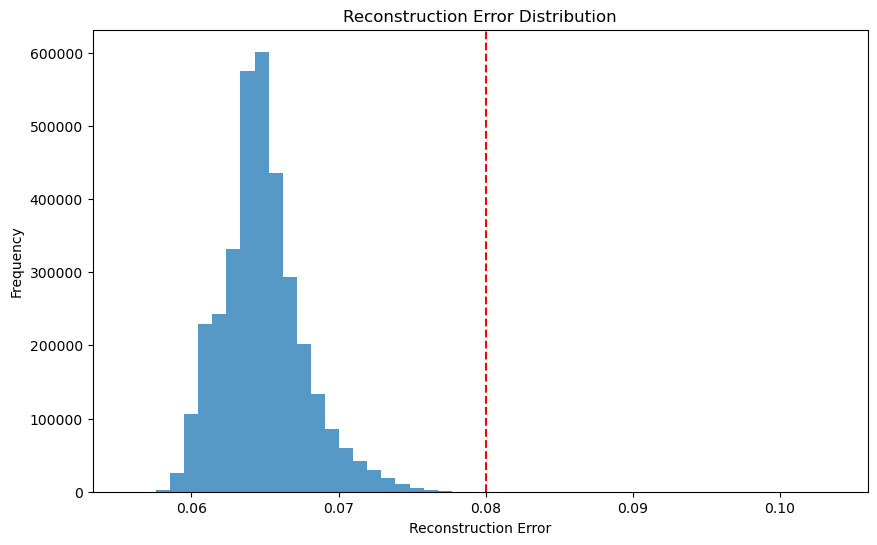

Detected 168 anomalies out of 3,432,780 samples.


In [9]:
# Directory where the separate Parquet files are stored
fragments_dir = r'X:\Processed_data'

# Iterate through the fragment files
fragment_files = [
    os.path.join(fragments_dir, f)
    for f in os.listdir(fragments_dir)
    if f.endswith('.parquet')
]

file_number = 1

# Ensure that device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the trained model
# Assuming 'model' is your trained model
# If you have saved the model, load it using:
# model.load_state_dict(torch.load('autoencoder_epoch_10.pth'))
model = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)
model.to(device)

# Read the data from the Parquet file
print(fragment_files[file_number])
parquet_file = pq.ParquetFile(fragment_files[file_number])
data_table = parquet_file.read()
data = data_table.to_pandas().to_numpy(dtype='float32')


# Call the detect_anomalies function
anomalies, reconstruction_errors = detect_anomalies_in_batches(data, model, device)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.08, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(data):,} samples.")

In [10]:
data_table = pq.read_table(fragment_files[file_number])
data_df = data_table.to_pandas()
data_df['reconstruction_error'] = reconstruction_errors
data_df['anomaly'] = anomalies

In [35]:
#data_df.head(25)

## Test på valideringsdata

In [6]:
freezer_number = "806031"

In [13]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

input_file = freezer_number + "_temp.parquet"  # Replace with the correct file name if needed

# Specify the columns to scale
columns_to_scale = [
    'RTD', '1st Suc.', 'Cond. Air In', 'Evap. In', 'Evap. Out', 
    '2nd Suc.', 'Chil. water In', '2nd Sump', 'H.E.', 
    'SetPoint', 'Mains Voltage'
]

# Load the combined data (assuming it's already saved as 'combined_data.parquet')
data = pd.read_parquet(path + input_file)

# Filter out rows where the freezer is off
data = data[(data['Mains Voltage'] >= 200)]

# Check if all columns are present in the dataset
missing_columns = [col for col in columns_to_scale if col not in data.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in the data: {missing_columns}")

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the specified columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Save the scaled dataset back to Parquet
scaled_output_file = "scaled_" + freezer_number + "_data.parquet"
data.to_parquet(path + scaled_output_file)

print(f"Scaled data saved as {scaled_output_file}")

Scaled data saved as scaled_806031_data.parquet


In [ ]:
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from dask.delayed import delayed
import os
import tempfile
import shutil
from joblib import Parallel, delayed as joblib_delayed
from tqdm import tqdm
import gc  # Import garbage collection module

##### Brug ML env #####

# Constants
input_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'
output_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'
window_size = 30
num_cores = -1  # Use all available cores

# List of freezer numbers to process
freezer_numbers = [ freezer_number ]

# Function to process a single freezer
def process_freezer(freezer_number):
    temp_dir = tempfile.mkdtemp()
    temp_output_file = os.path.join(temp_dir, f"processed_{freezer_number}_temp")
    final_output_file = os.path.join(output_path, f"test_ready_{freezer_number}.parquet")

    try:
        # Load data using Dask
        df = dd.read_parquet(input_path + f'scaled_{freezer_number}_data.parquet')
        
        # Step 1: Drop unnecessary columns
        drop_columns_set_1 = ['State', 'Type', 'Event']
        drop_columns_set_2 = drop_columns_set_1 + ['main_fault']
        if 'main_fault' in df.columns:
            df = df.drop(columns=[col for col in drop_columns_set_2 if col in df.columns])
        else:
            df = df.drop(columns=[col for col in drop_columns_set_1 if col in df.columns])

        # Convert to pandas for time-based operations
        df = df.compute()

        # Step 2: Ensure datetime format
        df['Datetime'] = pd.to_datetime(df['Datetime'])

        # Step 3: Identify continuous sequences
        df['time_diff'] = df['Datetime'].diff().dt.total_seconds()
        df['is_continuous'] = (df['time_diff'].between(1, 120)) | (df.index == 0)
        df['sequence_group'] = (~df['is_continuous']).cumsum()

        # Step 5: Filter valid sequences
        valid_sequences = df.groupby('sequence_group').filter(lambda x: len(x) >= window_size)

        print(valid_sequences.shape)

        datetime_file = "datetime_after_seq_" + freezer_number + ".parquet"
        valid_sequences[['Datetime']].to_parquet(input_path + datetime_file, index=False)

        # Get the original feature names
        feature_names = [col for col in valid_sequences.columns 
                         if col not in ['Datetime', 'time_diff', 'is_continuous', 'sequence_group']]

        # Step 6: Process groups in chunks
        def process_group(group):
            group_windows = []
            for start_idx in range(0, len(group) - window_size + 1):
                window = group.iloc[start_idx:start_idx + window_size]
                flattened_window = window.drop(
                    ['Datetime', 'time_diff', 'is_continuous', 'sequence_group'], axis=1
                ).values.flatten()
                group_windows.append(flattened_window)
            return group_windows

        # Process groups in chunks to manage memory
        chunk_size = 20
        groups = [group for _, group in valid_sequences.groupby('sequence_group')]
        num_chunks = (len(groups) + chunk_size - 1) // chunk_size

        # Create column names for the flattened data
        feature_columns = [f'feature_{i}_{t}' for i in range(window_size) for t in feature_names]

        # Process chunks and write to temporary file
        first_chunk = True

        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, len(groups))
            chunk_groups = groups[start_idx:end_idx]
            
            # Process chunk using parallel processing
            chunk_windows = Parallel(n_jobs=num_cores)(
                joblib_delayed(process_group)(group) for group in tqdm(
                    chunk_groups, 
                    desc=f"Processing Freezer {freezer_number} Chunk {chunk_idx + 1}/{num_chunks}",
                    unit="group"
                )
            )
            
            # Flatten the chunk results
            chunk_windows = [window for group_windows in chunk_windows for window in group_windows]
            
            # Convert chunk to DataFrame with proper column names
            chunk_df = pd.DataFrame(chunk_windows, columns=feature_columns)
            
            # Write chunk to temporary parquet file
            if first_chunk:
                chunk_df.to_parquet(temp_output_file, index=False)
                first_chunk = False
            else:
                chunk_df.to_parquet(temp_output_file, index=False, append=True)
            
            # Clear memory
            del chunk_windows
            del chunk_df
            gc.collect()  # Trigger garbage collection

        # Move the temporary file to the final location with a new name
        shutil.move(temp_output_file, final_output_file)
        
        print(f"Successfully saved processed file to: {final_output_file}")

    finally:
        # Clean up temporary directory
        try:
            shutil.rmtree(temp_dir)
        except:
            pass
        
        # Explicitly delete variables and run garbage collection
        del df, valid_sequences, groups, feature_names, drop_columns_set_1, drop_columns_set_2
        gc.collect()

# Process all freezers
for freezer_number in freezer_numbers:
    print(f"Processing freezer: {freezer_number}")
    process_freezer(freezer_number)

c:\Users\claes\anaconda3\envs\ML\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\claes\anaconda3\envs\ML\Lib\site-packages\dask\dataframe\io\parquet\core.py:1247: FutureWarning: Could not find pyarrow; falling back to fastparquet, which is deprecated and will be removed in a future release.
  warnings.warn(


Processing freezer: 806031


Processing Freezer 806031 Chunk 4/4: 100%|██████████| 14/14 [00:00<00:00, 36359.29group/s]


Successfully saved processed file to: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/test_ready_806031.parquet


In [2]:
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from dask.delayed import delayed
import os
import tempfile
import shutil
from joblib import Parallel, delayed as joblib_delayed
from tqdm import tqdm
import gc  # Import garbage collection module

##### Brug ML env #####

# Constants
input_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'
output_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'
window_size = 30
num_cores = -1  # Use all available cores

# List of freezer numbers to process
freezer_numbers = [ freezer_number ]

# Function to process a single freezer
def process_freezer(freezer_number):
    temp_dir = tempfile.mkdtemp()
    temp_output_file = os.path.join(temp_dir, f"processed_{freezer_number}_temp")
    final_output_file = os.path.join(output_path, f"test_ready_{freezer_number}.parquet")

    try:
        # Load data using Dask
        df = dd.read_parquet(input_path + f'scaled_{freezer_number}_data.parquet')
        
        # Step 1: Drop unnecessary columns
        drop_columns_set_1 = ['State', 'Type', 'Event']
        drop_columns_set_2 = drop_columns_set_1 + ['main_fault']
        if 'main_fault' in df.columns:
            df = df.drop(columns=[col for col in drop_columns_set_2 if col in df.columns])
        else:
            df = df.drop(columns=[col for col in drop_columns_set_1 if col in df.columns])

        # Convert to pandas for time-based operations
        df = df.compute()

        # Step 2: Ensure datetime format
        df['Datetime'] = pd.to_datetime(df['Datetime'])

        # Step 3: Identify continuous sequences
        df['time_diff'] = df['Datetime'].diff().dt.total_seconds()
        df['is_continuous'] = (df['time_diff'].between(1, 120)) | (df.index == 0)
        df['sequence_group'] = (~df['is_continuous']).cumsum()

        # Step 5: Filter valid sequences
        valid_sequences = df.groupby('sequence_group').filter(lambda x: len(x) >= window_size)

        # Get the original feature names
        feature_names = [col for col in valid_sequences.columns 
                         if col not in ['Datetime', 'time_diff', 'is_continuous', 'sequence_group']]

        def process_group(group):
            group_windows = []
            datetime_output = []  # Store one Datetime per flattened window

            for start_idx in range(0, len(group) - window_size + 1):
                window = group.iloc[start_idx:start_idx + window_size]
                
                # Save the first 'Datetime' of the window as representative for the flattened window
                datetime_output.append(window['Datetime'].iloc[0])
                
                # Flatten the other columns (excluding 'Datetime')
                flattened_window = window.drop(
                    ['Datetime', 'time_diff', 'is_continuous', 'sequence_group'], axis=1
                ).values.flatten()
                group_windows.append(flattened_window)
            
            return group_windows, datetime_output

        # Process groups in chunks to manage memory
        chunk_size = 20
        groups = [group for _, group in valid_sequences.groupby('sequence_group')]
        num_chunks = (len(groups) + chunk_size - 1) // chunk_size

        # Create column names for the flattened data
        feature_columns = [f'feature_{i}_{t}' for i in range(window_size) for t in feature_names]

        # Process chunks and write to temporary file
        first_chunk = True

        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, len(groups))
            chunk_groups = groups[start_idx:end_idx]
            
            # Process chunk using parallel processing
            chunk_results = Parallel(n_jobs=num_cores)(
                joblib_delayed(process_group)(group) for group in tqdm(
                    chunk_groups, 
                    desc=f"Processing Freezer {freezer_number} Chunk {chunk_idx + 1}/{num_chunks}",
                    unit="group"
                )
            )
            
            # Split the results into data windows and datetime outputs
            chunk_windows, datetime_outputs = zip(*chunk_results)

            # Flatten the chunk results
            chunk_windows = [window for group_windows in chunk_windows for window in group_windows]
            datetime_outputs = [dt for group_datetimes in datetime_outputs for dt in group_datetimes]

            # Convert chunk to DataFrame
            chunk_df = pd.DataFrame(chunk_windows, columns=feature_columns)
            chunk_df['Datetime'] = datetime_outputs  # Add Datetime column to the output DataFrame

            # Write processed data to temporary parquet file
            if first_chunk:
                chunk_df.to_parquet(temp_output_file, index=False)
                first_chunk = False
            else:
                chunk_df.to_parquet(temp_output_file, index=False, append=True)
            
            # Clear memory
            del chunk_windows, datetime_outputs, chunk_df
            gc.collect()

        # Move the temporary file to the final location with a new name
        shutil.move(temp_output_file, final_output_file)
        
        print(f"Successfully saved processed file to: {final_output_file}")

    finally:
        # Clean up temporary directory
        try:
            shutil.rmtree(temp_dir)
        except:
            pass
        
        # Explicitly delete variables and run garbage collection
        del df, valid_sequences, groups, feature_names, drop_columns_set_1, drop_columns_set_2
        gc.collect()

# Process all freezers
for freezer_number in freezer_numbers:
    print(f"Processing freezer: {freezer_number}")
    process_freezer(freezer_number)

c:\Users\claes\anaconda3\envs\ML\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\claes\anaconda3\envs\ML\Lib\site-packages\dask\dataframe\io\parquet\core.py:1247: FutureWarning: Could not find pyarrow; falling back to fastparquet, which is deprecated and will be removed in a future release.
  warnings.warn(


Processing freezer: 806031


Processing Freezer 806031 Chunk 4/4: 100%|██████████| 14/14 [00:00<00:00, 13937.87group/s]


Successfully saved processed file to: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/test_ready_806031.parquet


In [ ]:
path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'


#data_df = pd.read_parquet(path + "806031_temp.parquet")
#data_df = pd.read_parquet(path + "scaled_806031_data.parquet")
data_df = pd.read_parquet(path + "test_ready_806031.parquet")

path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

data_df = pd.read_parquet(path + "test_ready_" + freezer_number + ".parquet")

data_df = data_df.drop(['Datetime'], axis=1)

data_df.head()

,feature_0_RTD,feature_0_1st Suc.,feature_0_Cond. Air In,feature_0_Evap. In,feature_0_Evap. Out,feature_0_2nd Suc.,feature_0_Chil. water In,feature_0_2nd Sump,feature_0_H.E.,feature_0_SetPoint,...,feature_29_Cond. Air In,feature_29_Evap. In,feature_29_Evap. Out,feature_29_2nd Suc.,feature_29_Chil. water In,feature_29_2nd Sump,feature_29_H.E.,feature_29_SetPoint,feature_29_Mains Voltage,Datetime
0,0.975287,0.6714,0.642140,0.958229,0.954625,0.893953,0.348609,0.239460,0.960610,0.0,...,0.729097,0.068505,0.964223,0.826468,0.414075,0.431703,0.155019,0.0,0.483384,2012-09-17 17:27:05
1,0.975287,0.6714,0.645485,0.958229,0.954625,0.893953,0.346972,0.237774,0.958069,0.0,...,0.735786,0.068505,0.964223,0.826468,0.414075,0.440135,0.155019,0.0,0.453172,2012-09-17 17:28:05
2,0.975287,0.6714,0.645485,0.958229,0.954625,0.893953,0.348609,0.237774,0.958069,0.0,...,0.735786,0.068505,0.965096,0.826468,0.415712,0.451939,0.155019,0.0,0.453172,2012-09-17 17:29:05
3,0.975287,0.6714,0.645485,0.959064,0.955497,0.893953,0.348609,0.236088,0.960610,0.0,...,0.742475,0.068505,0.965096,0.826468,0.415712,0.465430,0.155019,0.0,0.453172,2012-09-17 17:30:05
4,0.975287,0.6714,0.648829,0.959900,0.955497,0.893953,0.348609,0.236088,0.964422,0.0,...,0.742475,0.068505,0.965096,0.827344,0.415712,0.477234,0.155019,0.0,0.453172,2012-09-17 17:31:05


(5062171, 16)
(5062073, 1)
(5059927, 330)

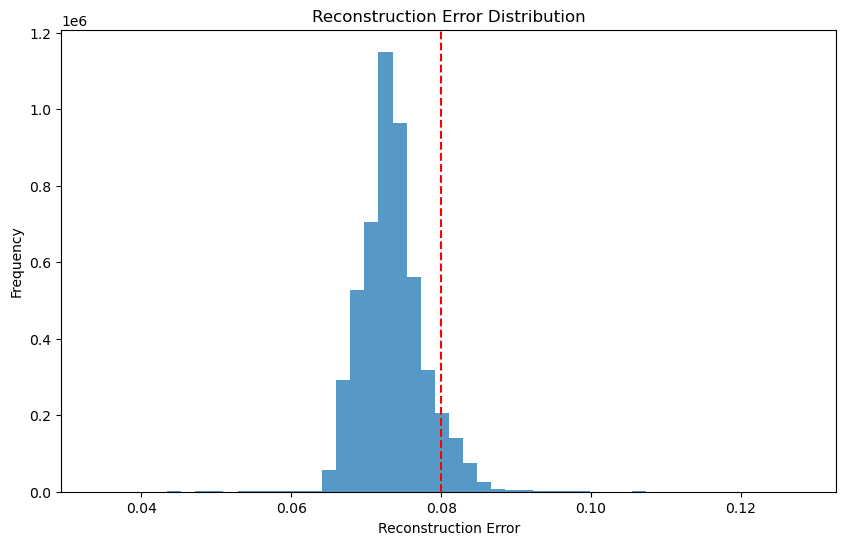

Detected 373,515 anomalies out of 5,059,927 samples.


In [ ]:
path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

data_df = pd.read_parquet(path + "test_ready_" + freezer_number + ".parquet")

data_df = data_df.drop(columns=['Datetime'])

# Ensure that device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)
model.to(device)

data = data_df.to_numpy(dtype='float32')

# Call the detect_anomalies function
anomalies, reconstruction_errors = detect_anomalies_in_batches(data, model, device)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.08, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(data):,} samples.")

## Test på valideringsdata

In [8]:
freezer_number = "806031"

In [9]:
import os
import torch
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import gc  # Garbage collection

# Define the detect_anomalies function with batch processing
def detect_anomalies_in_batches(data, model, device, batch_size=512, threshold=0.08):
    model.eval()
    dataset = torch.utils.data.TensorDataset(torch.tensor(data, dtype=torch.float32))  # Shape: (num_windows, seq_len, num_features)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            data_tensor = batch[0].to(device)  # Shape: (batch_size, seq_len, num_features)
            outputs = model(data_tensor)
            x_hat = outputs['x_hat']
            # Compute reconstruction errors for each sequence
            batch_errors = torch.mean((data_tensor - x_hat) ** 2, dim=(1, 2)).cpu().numpy()
            reconstruction_errors.extend(batch_errors)
    
    reconstruction_errors = np.array(reconstruction_errors)
    anomalies = reconstruction_errors > threshold
    return anomalies, reconstruction_errors

def reshape_to_sliding_windows(data, window_size):
    num_samples, num_features = data.shape
    windows = []
    for i in range(num_samples - window_size + 1):
        windows.append(data[i:i + window_size])  # Collect sliding windows
    return np.array(windows, dtype=np.float32)

# Define sliding window processing function
def process_chunk(data_chunk, model, device, window_size, batch_size, threshold):
    # Convert data into sliding windows
#    data_chunk = reshape_to_sliding_windows(data_chunk, window_size)
    # Detect anomalies in the chunk
    anomalies, reconstruction_errors = detect_anomalies_in_batches(data_chunk, model, device, batch_size, threshold)
    return anomalies, reconstruction_errors

In [10]:
import os
import torch
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc  # Garbage collection
import tempfile

path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load trained linear model
model = AutoEncoder(hidden_units1, hidden_units2, hidden_units3, latent_features)
model.to(device)

# Parameters
batch_size = 512
threshold = 0.08
chunk_size = 10_000  # Reduce chunk size for better memory management

# Temporary directory for storing intermediate results
temp_dir = tempfile.TemporaryDirectory()

print("Processing file:" + "test_ready_" + freezer_number + ".parquet")
parquet_file = pq.ParquetFile(path + "test_ready_" + freezer_number + ".parquet")

chunk_files = []  # To keep track of temporary files

for row_group_idx in range(parquet_file.num_row_groups):
    print(f"Processing row group {row_group_idx + 1}/{parquet_file.num_row_groups}")
    
    # Read a row group into memory
    data_chunk = parquet_file.read_row_group(row_group_idx).to_pandas()
    
    # Keep 'Datetime' column separately
    if 'Datetime' in data_chunk.columns:
        datetimes = data_chunk['Datetime']
        data_chunk = data_chunk.drop(columns=['Datetime'])
    else:
        datetimes = None
    
    # Convert to NumPy array
    data_chunk_np = data_chunk.to_numpy(dtype='float32')
    num_rows = data_chunk_np.shape[0]
    
    # Split the row group into smaller chunks
    for start_idx in range(0, num_rows, chunk_size):
        end_idx = min(start_idx + chunk_size, num_rows)
        chunk_df = data_chunk.iloc[start_idx:end_idx]  # Retain original columns
        chunk_datetimes = datetimes[start_idx:end_idx] if datetimes is not None else None
        chunk_np = data_chunk_np[start_idx:end_idx]
        
        # Process the current chunk
        anomalies, reconstruction_errors = process_chunk(chunk_np, model, device, batch_size, threshold)
        
        # Create a DataFrame for the current chunk
        chunk_results = pd.DataFrame({
            'Datetime': chunk_datetimes.values if chunk_datetimes is not None else None,
            'reconstruction_error': reconstruction_errors,
            'anomaly': anomalies
        })
        for col in chunk_df.columns:
            chunk_results[col] = chunk_df[col].values
        
        # Write the chunk results to a temporary file
        temp_file_path = os.path.join(temp_dir.name, f"chunk_{row_group_idx}_{start_idx}.parquet")
        chunk_results.to_parquet(temp_file_path, index=False)
        chunk_files.append(temp_file_path)
        
        # Clear memory
        del chunk_df, chunk_np, chunk_results
        gc.collect()  # Trigger garbage collection
    
    # Clear row group data after processing
    del data_chunk, data_chunk_np
    gc.collect()

# Combine all temporary files into a single DataFrame
results_df = pd.concat([pd.read_parquet(f) for f in chunk_files], ignore_index=True)

# Cleanup temporary files
temp_dir.cleanup()

Using device: cuda
Processing file:test_ready_806031.parquet
Processing row group 1/4


TypeError: process_chunk() missing 1 required positional argument: 'threshold'